# Data Collection Notebook

This notebook collects data from the pitot tube sensor as the Jetbot rotates in a circle. A fan is blowing towards the center of the circle such that the pitot tube is parallel to the flow once every rotation.

The point of collecting this data is to get an idea of the type of data that the GP will have to model and predict for - the goal is to build a model off-line using this data (and potentially simulated data that is similar to the collected data), and then adapt it for an on-line GP prediction model.

## Package Imports

In [1]:
from qwiic_ads1115.qwiic_ads1115 import QwiicAds1115
import time
from jetbot import Robot
from jetbot import Heartbeat
import ipywidgets.widgets as widgets
from IPython.display import display
import traitlets
import numpy as np

Error loading module `ublox_gps`: No module named 'serial'


## Initialize the ADS1115 Pressure Sensor

In [2]:
ads = QwiicAds1115()
ads.os = '0' # no effect
ads.mux = '100' # Analog In, channel 0, compare to GND
ads.gain = '000' # +/- 6.144V
ads.mode = '0' # continuous
ads.data_rate = '100' # 128 SPS
ads.comp_que = '11' # disable comparator
ads.scale = 1 # 1V = 1kPa delta between ports
if ads.is_connected():
    ads.configure()
    time.sleep(0.5)
    ads.calibrate()
    
    # Confirm calibration set:
    if abs(ads.get_measurement()) > 0.1:
        print("Pressure calibration has likely failed")
    else:
        print("ADS1115 successfully initialized and calibrated")
else:
    print("ADS1115 not connected")
        

ADS1115 successfully initialized and calibrated


## Setup the Fan

Manually power on the fan now and place radially to the Jetbot's path (for simplicity, place orthogonal to the Jetbots current orientation). In the following code, the Jetbot will be programmed to travel in a circle approximitely 1 meter in diameter.

## Start the Jetbot Motion

In [3]:
robot = Robot()

In [4]:
# Heartbeat kill switch, from basic_motion.py example notebook

heartbeat = Heartbeat()

# this function will be called when heartbeat 'alive' status changes
def handle_heartbeat_status(change):
    if change['new'] == Heartbeat.Status.dead:
        robot.stop()
        
heartbeat.observe(handle_heartbeat_status, names='status')

period_slider = widgets.FloatSlider(description='period', min=0.001, max=1.0, step=0.01, value=1.0)
traitlets.dlink((period_slider, 'value'), (heartbeat, 'period'))

display(period_slider, heartbeat.pulseout)

FloatSlider(value=0.5, description='period', max=0.5, min=0.001, step=0.01)

FloatText(value=1714334844.2540154)

In [4]:
robot = Robot()

In [5]:
# calibrate right before data collection to account for drift
ads.calibrate()

# adjust as needed to get a circle of ~1m in diameter
robot.left_motor.value = 0.6*0.8
robot.right_motor.value = 0.4*0.8

In [7]:
robot.stop()

## Data Collection

In [6]:
# dictionary of data sampling rates
rates = {'000': 8, '001': 16, '010': 32, '011': 64, '100': 128, '101': 250, '110': 475, '111': 860}
# ts = 1/rates[ads.data_rate] # sampling period
ts = 1/rates['011'] # NOTE: hard-code 64Hz - may be slower than actual data_rate
tcollect = 80 # seconds to collect data
n = tcollect/ts
data = np.zeros((int(n),2))

i = 0
t0 = time.time()
tm = t0
# ts/2 in the while loop evaluation adds some buffer
while tm < t0 + tcollect + ts:
    # measurement + time of measurement
    tm = time.time()
    meas = ads.measure
    
    # add to the data array
    if i < n:
        data[i,:] = [tm, meas]
    
    i += 1
    
    tdelta = t0 + ts * i - time.time()
    if tdelta < 0:
        continue
    else:
        time.sleep(tdelta)
    
# save the measurement array for later use. time-stamp data collection with YYYY-MM-DDThhmmss
fn = "data/sample_data_" + time.strftime("%Y_%m_%dT%H%M%S",time.localtime()) + ".csv"
np.savetxt(fn,data, delimiter=',')

## Visualize Data

In [2]:
import matplotlib.pyplot as plt

In [14]:
# import data?
import pandas as pd
data_in = pd.read_csv('data/sample_data_2024_04_28T220150.csv', sep=',', header=None)
data = data_in.values

In [15]:
(data[0,0] - data[-1,0])/len(data)

-0.015621891198679804

In [16]:
ts = 1/64

<function matplotlib.pyplot.show(close=None, block=None)>

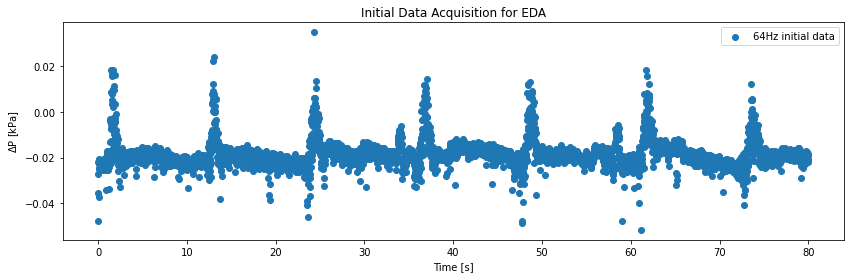

In [17]:
fig = plt.figure(figsize=(14,4))

plt.scatter(data[:,0] - data[0,0],data[:,1], label=str(int(1/ts))+"Hz initial data")
plt.title('Initial Data Acquisition for EDA')
plt.xlabel('Time [s]')
plt.ylabel(r'$\Delta$P [kPa]')
plt.legend()
plt.show

It's interesting to note that in the plot for data collected in file `Notebooks/ae8803/Final_Project/data/sample_data_2024_04_28T220150.csv`, you can see that there is a small spike whenever I move the Jetbot so that it continues to move in a circle without bumping into my bookshelf (the circle motion of the bot is not perfect). This could be higher noise, or it could also be that I'm moving the robot fast enough for it to detect motion.